In [61]:
# A few imports to make everything work

import pandas as pd
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from itertools import cycle

# Getting rid of a few warnings (can be toggled off)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:

url="https://raw.githubusercontent.com/fmtibaa/Bayesian_Project_A1/main/content/final.csv"
df_final=pd.read_csv(url,low_memory=False)

#### Correlations to Valore

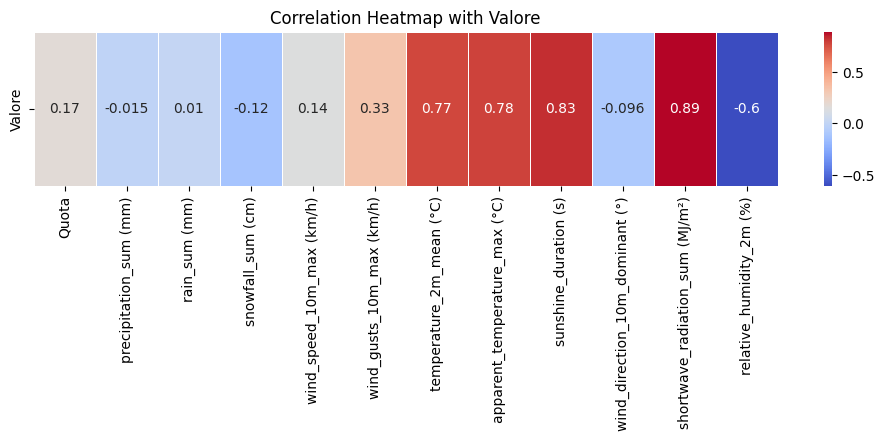

In [42]:

correlation_matrix =  df_final[["Valore", "Quota", 'precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)', 'wind_speed_10m_max (km/h)', 'wind_gusts_10m_max (km/h)'
,'temperature_2m_mean (°C)', 'apparent_temperature_max (°C)', 'sunshine_duration (s)', 'wind_direction_10m_dominant (°)', 'shortwave_radiation_sum (MJ/m²)', 'relative_humidity_2m (%)']].corr()

valore_correlations = correlation_matrix.loc[['Valore'], :].iloc[:,1:]


plt.figure(figsize=(12, 2))
sns.heatmap(valore_correlations, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap with Valore')
plt.show()

#### Boxplot of the weekly average ozone concentration level over years

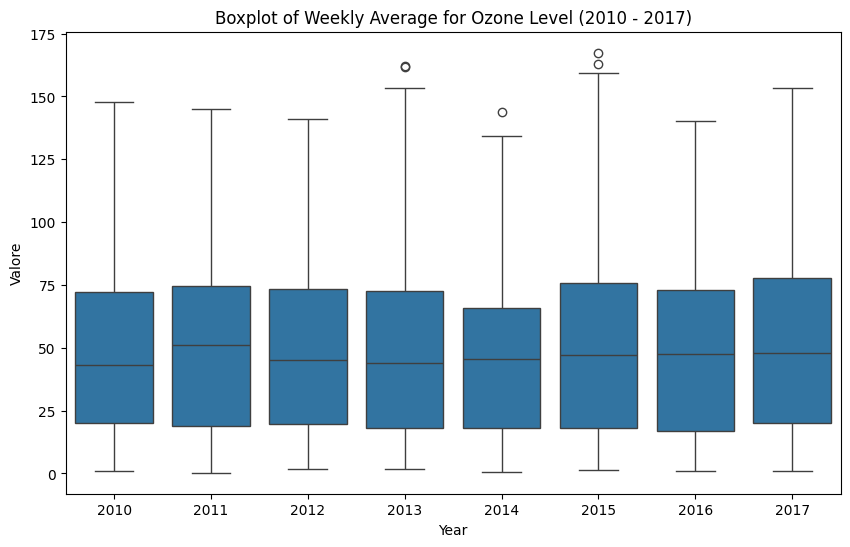

In [48]:
# Group by date and calculate the sum for each date
grouped_data = df_final.groupby(df_final["Data"]).mean()
df_final_copy = df_final.copy()

grouped_data = df_final_copy.groupby(df_final.index).mean() # Group by date and calculate the sum for each date
df_final_copy['Data'] = pd.to_datetime(df_final_copy['Data']) # Convert the 'Date' column to a datetime object

# Extract the year and create a new 'Year' column
df_final_copy['Year'] = df_final_copy['Data'].dt.year; grouped_data['Year'] = df_final_copy['Data'].dt.year

plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.boxplot(x='Year', y='Valore', data=grouped_data)
plt.title('Boxplot of Weekly Average for Ozone Level (2010 - 2017)')
plt.show()

#### Valore Outlier Detection via IQR

In [50]:
q1 = df_final_copy['Valore'].quantile(0.25)
q3 = df_final_copy['Valore'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df_final_copy[(df_final_copy['Valore'] < lower_bound) | (df_final_copy['Valore'] > upper_bound)]

print("Outliers: ", np.array(outliers.Valore)) # Display the outliers

Outliers:  [161.95178571 161.53809524 158.42738095 163.01796407 167.37857143
 157.27440476 159.4077381 ]


#### Kurtosis and Skewness of Valore

kurtosis: -0.808862667021601
skewness: 0.3505046880097886


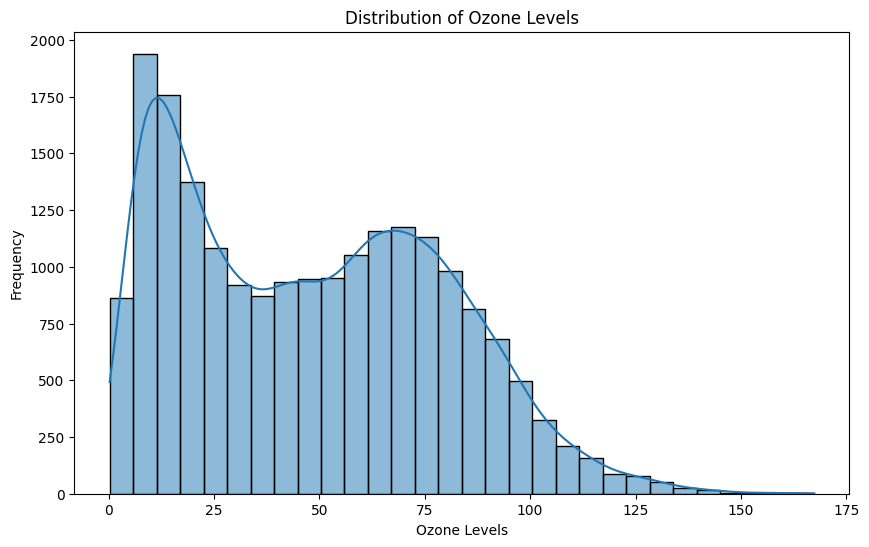

In [53]:
# Calculate the skewness and kurtosis of 'Valore'
skewness = df_final['Valore'].skew()
kurtosis = df_final['Valore'].kurtosis()
print(f'kurtosis: {kurtosis}')
print(f'skewness: {skewness}')

plt.figure(figsize=(10, 6))
sns.histplot(df_final['Valore'], bins=30, kde=True)
plt.xlabel('Ozone Levels')
plt.ylabel('Frequency')
plt.title('Distribution of Ozone Levels')
plt.show()

#### Plotting Missing Values for each Sensore

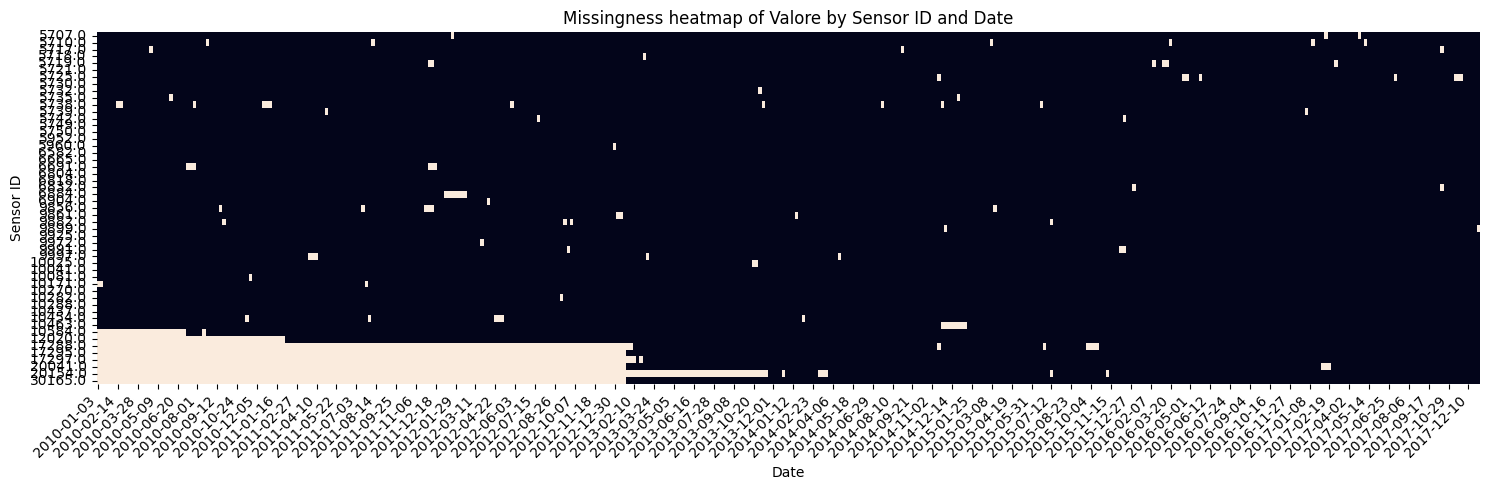

In [56]:
pivoted_df = df_final.pivot(index='idSensore', columns='Data', values='Valore') # Pivot the DataFrame
missingness_df = pivoted_df.isna() # Convert to boolean DataFrame where True indicates missing values

plt.figure(figsize=(15, 5))
sns.heatmap(missingness_df, cbar=False, yticklabels=True)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Sensor ID')
plt.title('Missingness heatmap of Valore by Sensor ID and Date')
plt.tight_layout()
plt.show()


#### Spatial Analysis

In [59]:
url = 'https://raw.githubusercontent.com/fmtibaa/Bayesian_Project_A1/main/content/lombardy.geojson'

gdf = gpd.read_file(url) # Read the GeoJSON file

df = df_final.copy()

# Convert coordinate strings to Point objects
def parse_coordinates(coord_str):
    lat, lng = map(float, coord_str.strip('()').split(', '))
    return Point(lng, lat)

df['geometry'] = df['location'].apply(parse_coordinates)

# Convert df to a GeoDataFrame and set the CRS to EPSG:4326 (for latitude and longitude)
gdf_points = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# If your Lombardy GeoDataFrame (gdf) is not in the same CRS, change it to match
gdf = gdf.to_crs("EPSG:4326")

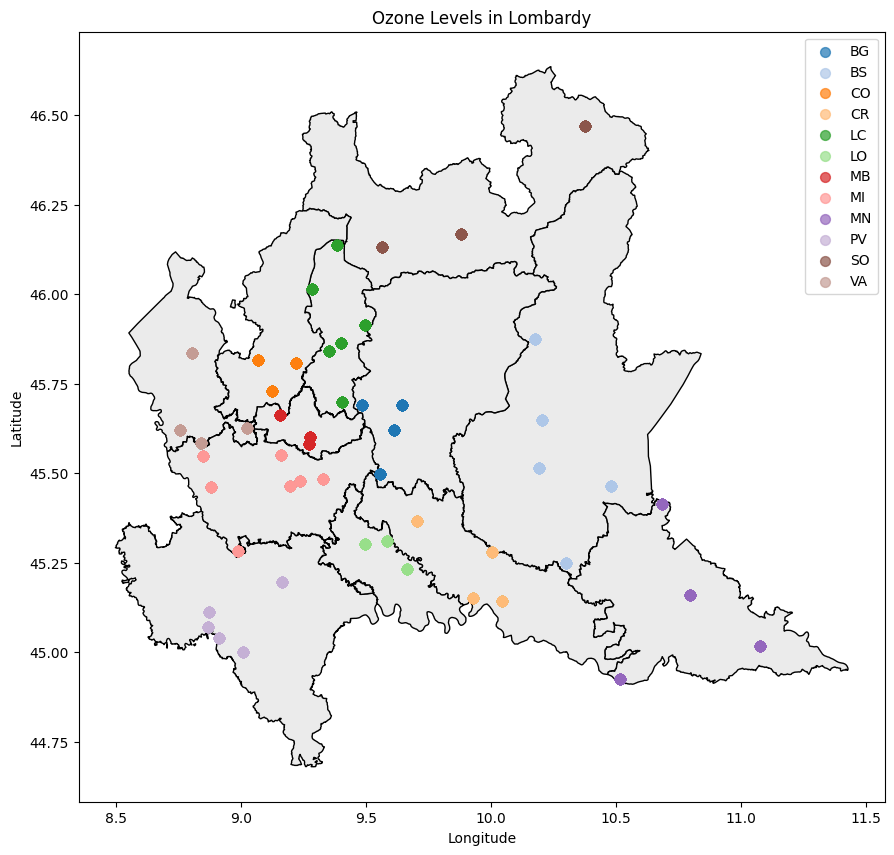

In [60]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Lombardy region map
gdf.plot(ax=ax, color='#ebebeb', edgecolor='black')

colors = cycle(plt.cm.tab20.colors)
for province, group in gdf_points.groupby('Provincia'):
    color = next(colors)
    group.plot(ax=ax, markersize=50, alpha=0.7, color=color, marker='o', label=province)

# Adding titles and labels
plt.title('Ozone Levels in Lombardy')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()